# Project_16 - NLP (Reviews)

## Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [3]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('datasets/project_09_dataset.csv')
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [5]:
#df_reviews.to_csv('~/work/project_datasets/project_09_dataset.csv', index=False, header=list(df_reviews.columns))

In [26]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [27]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA

Let's check the number of movies and reviews over years.

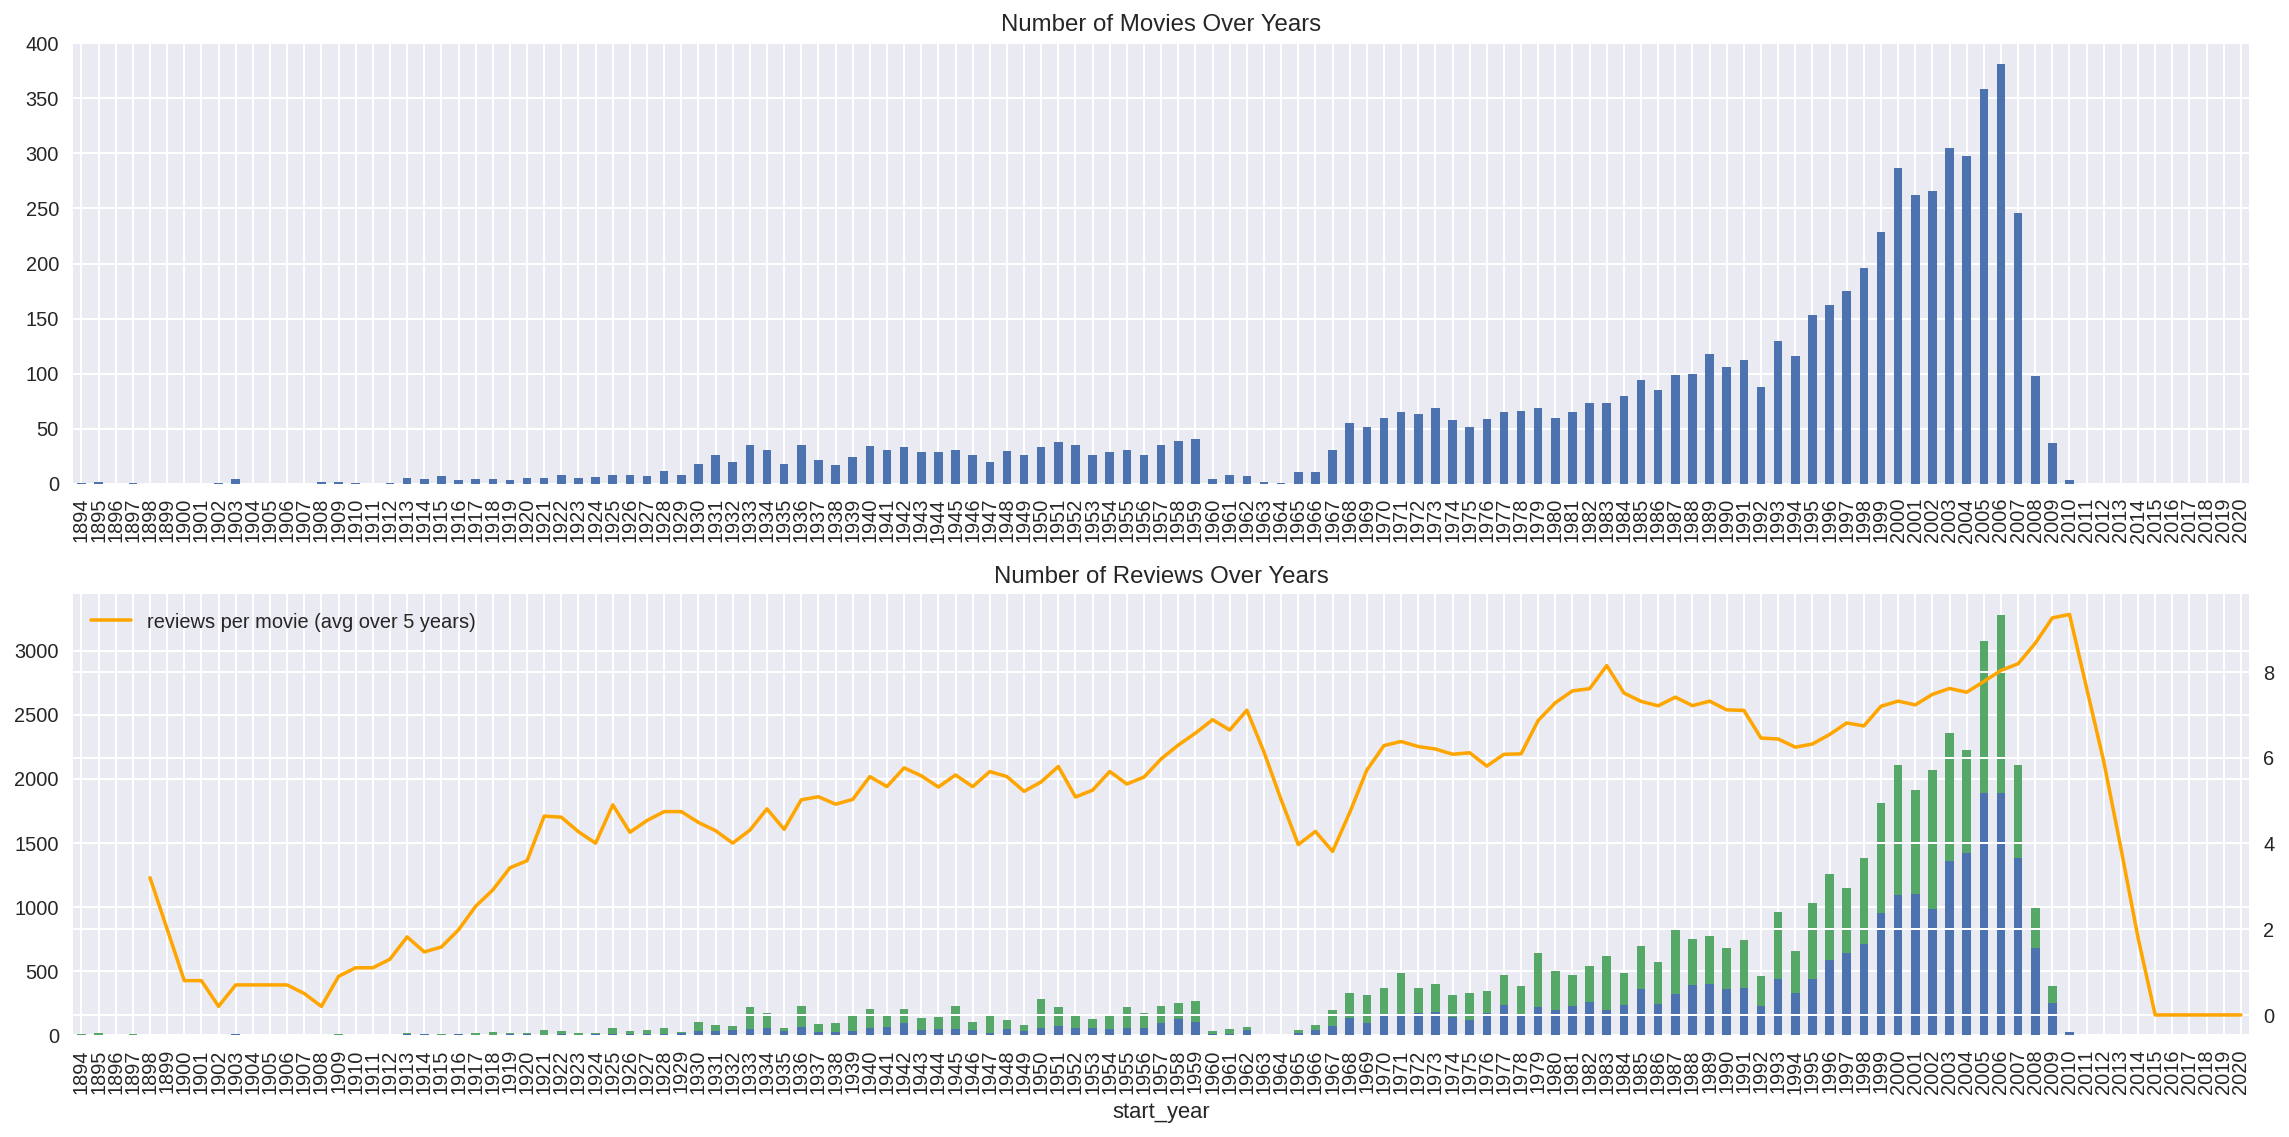

In [28]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

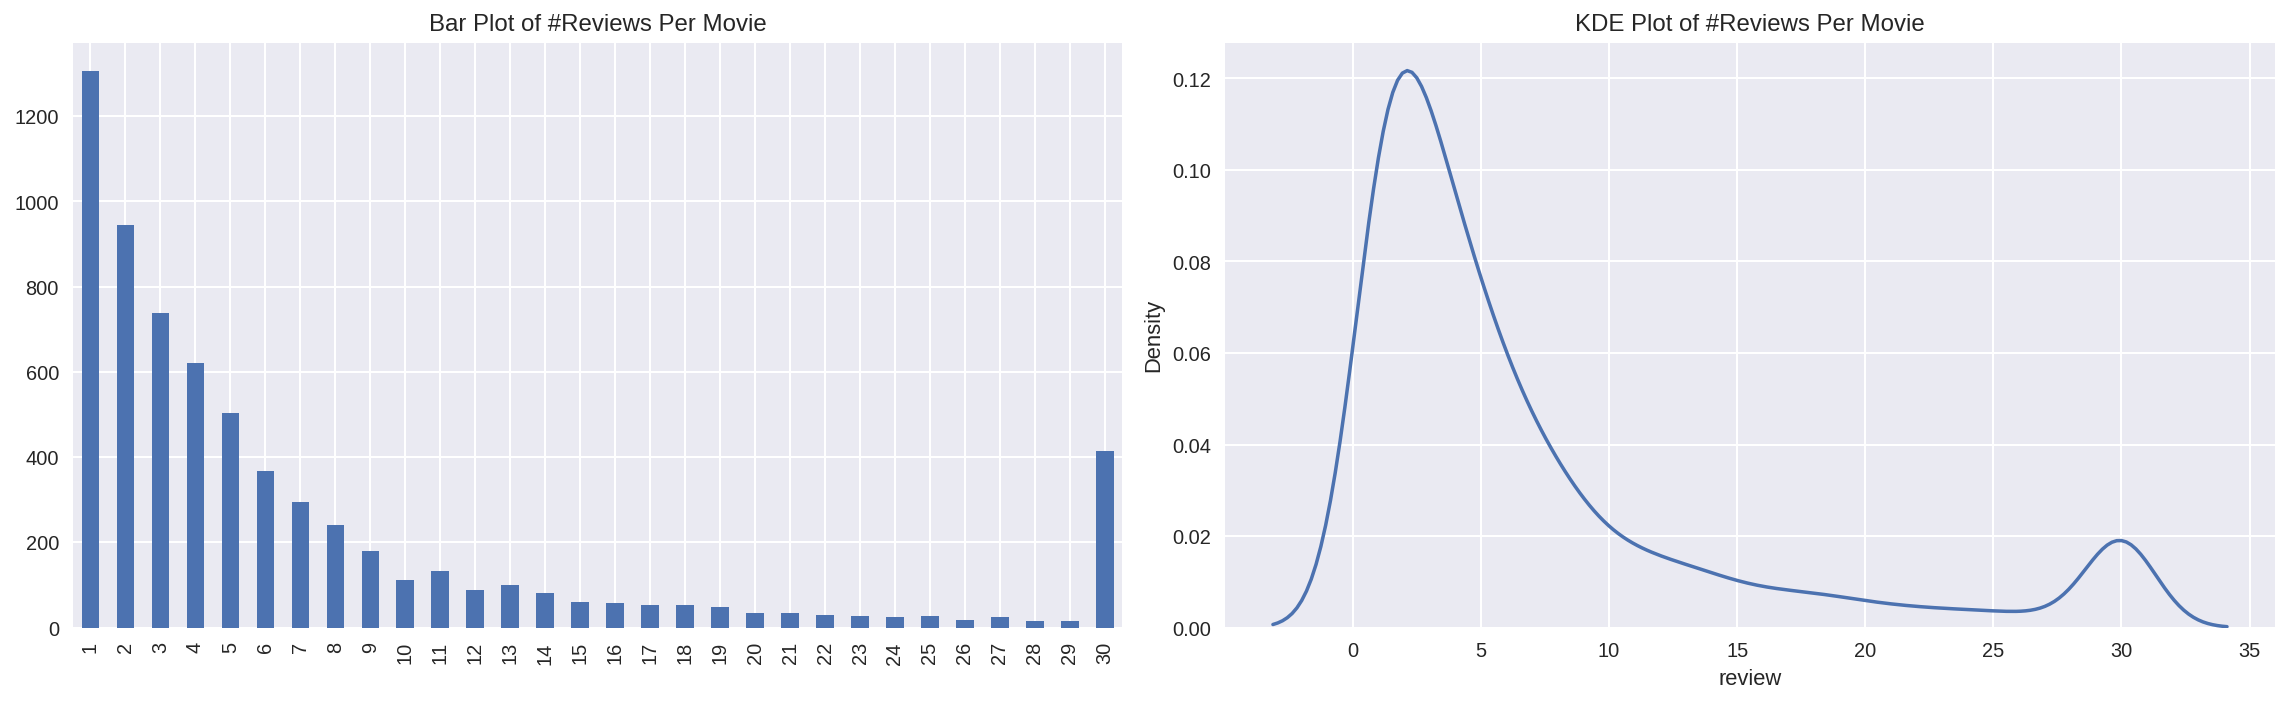

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [30]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

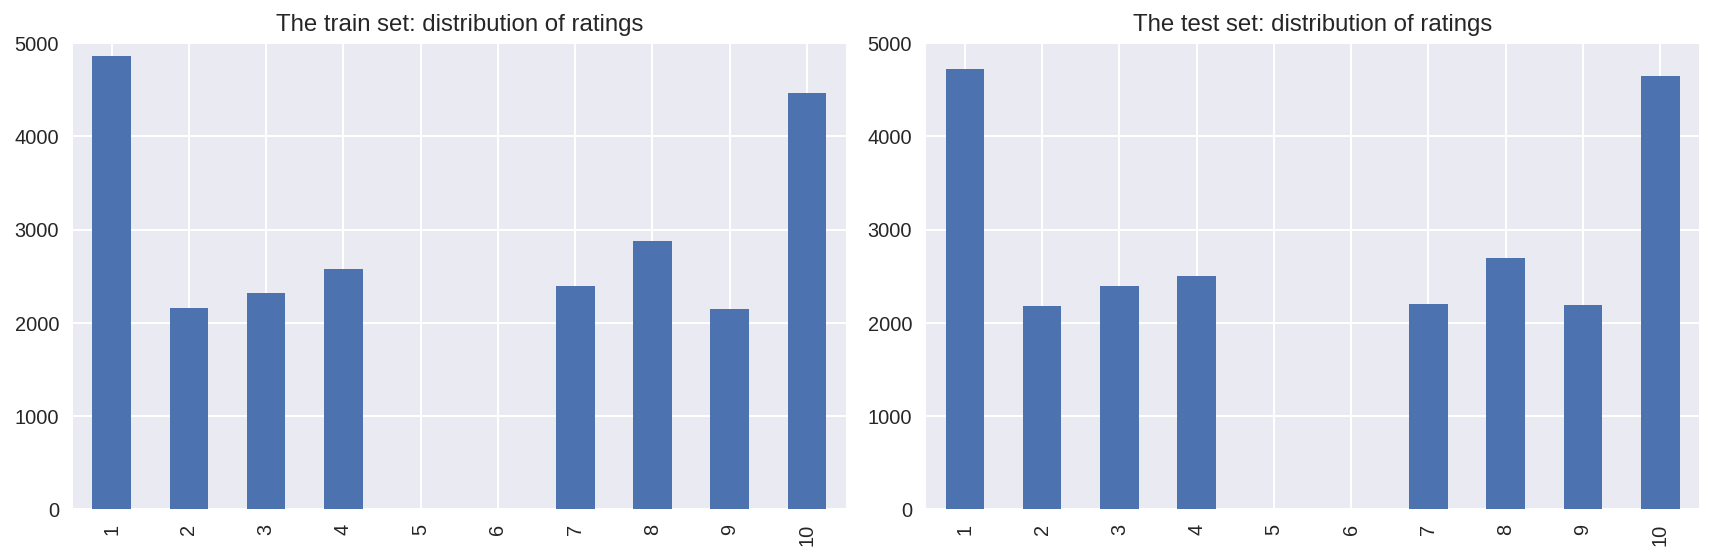

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


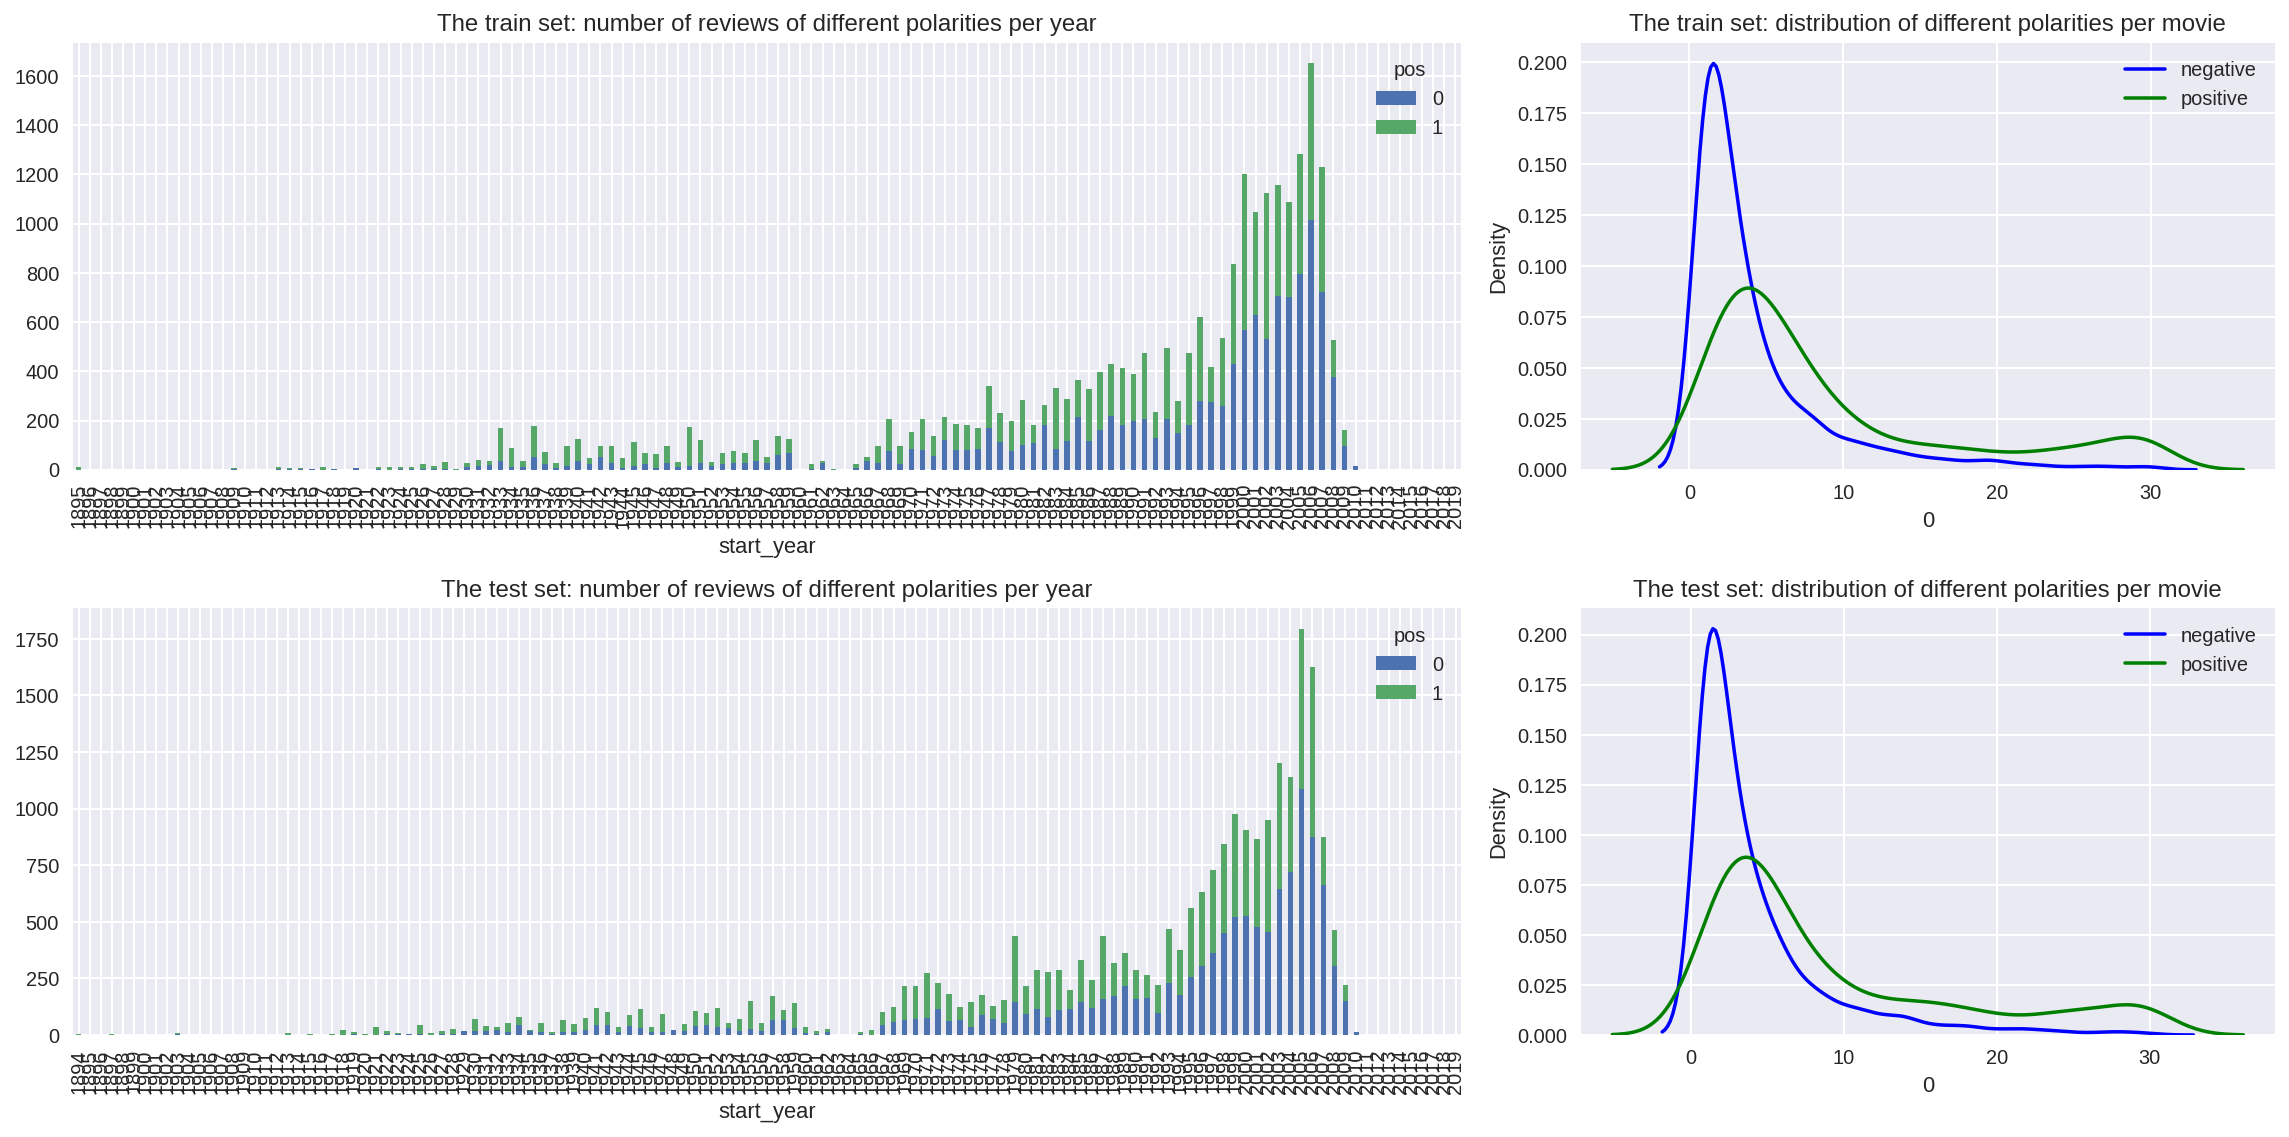

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [33]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [34]:
df_reviews.head(3)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489


In [35]:
import re

def normalize(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, ' ', text)
    text = text.split()
    text = " ".join(text)
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(normalize)

In [36]:
display(df_reviews['review_norm'][0])

"The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery but that's not what I got out of it I didn't get anything In the first half there's a new character without introduction in every other scene The first half hour is completely incomprehensible the rest is just one long annoying underlit chase scene There's always an irritating sound in the background whether it's a loud watch ticking a blaring siren a train whistling or even the horrible score by Quincy Jones There are a lot of parts that are laughably bad too Like the bad guys chasing Beatty on thin ice with a CAR Or the police arriving at the scene roughly fifteen times I really hated this movie"

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [37]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [38]:
df_reviews_train.head(3)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,The pakage implies that Warren Beatty and Gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,How the hell did they get this made Presenting...
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903,This true story of Carlson's Raiders is more o...


In [39]:
df_reviews_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23796 entries, 0 to 47257
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           23796 non-null  object 
 1   title_type       23796 non-null  object 
 2   primary_title    23796 non-null  object 
 3   original_title   23796 non-null  object 
 4   start_year       23796 non-null  int64  
 5   end_year         23796 non-null  object 
 6   runtime_minutes  23796 non-null  object 
 7   is_adult         23796 non-null  int64  
 8   genres           23796 non-null  object 
 9   average_rating   23796 non-null  float64
 10  votes            23796 non-null  Int64  
 11  review           23796 non-null  object 
 12  rating           23796 non-null  int64  
 13  sp               23796 non-null  object 
 14  pos              23796 non-null  int64  
 15  ds_part          23796 non-null  object 
 16  idx              23796 non-null  int64  
 17  review_norm 

## Working with models

### Model 0 - Constant

In [40]:
from sklearn.dummy import DummyClassifier

In [41]:
train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']
train_features.head()

0    The pakage implies that Warren Beatty and Gold...
1    How the hell did they get this made Presenting...
7    This true story of Carlson's Raiders is more o...
8    Should have been titled 'Balderdash ' Little i...
9    The movie 'Gung Ho ' The Story of Carlson's Ma...
Name: review_norm, dtype: object

In [42]:
train_features.shape, test_features.shape

((23796,), (23535,))

In [43]:
dc = DummyClassifier()
dc.fit(train_features, train_target)
dc.score(train_features, train_target)

0.5005883341738108

In [44]:
dc.score(test_features, test_target)

0.5015083917569577

### Model  - NLTK, TF-IDF and LR

TF-IDF

In [66]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [67]:
stop_words = set(stopwords.words('english'))
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 1))
train_bow_2 = tfidf_vectorizer_2.fit_transform(train_features)
test_bow_2 = tfidf_vectorizer_2.transform(test_features)

In [68]:
train_bow_2.shape, test_bow_2.shape

((23796, 71531), (23535, 71531))

In [69]:
model_2 = LogisticRegression()
model_2.fit(train_bow_2, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


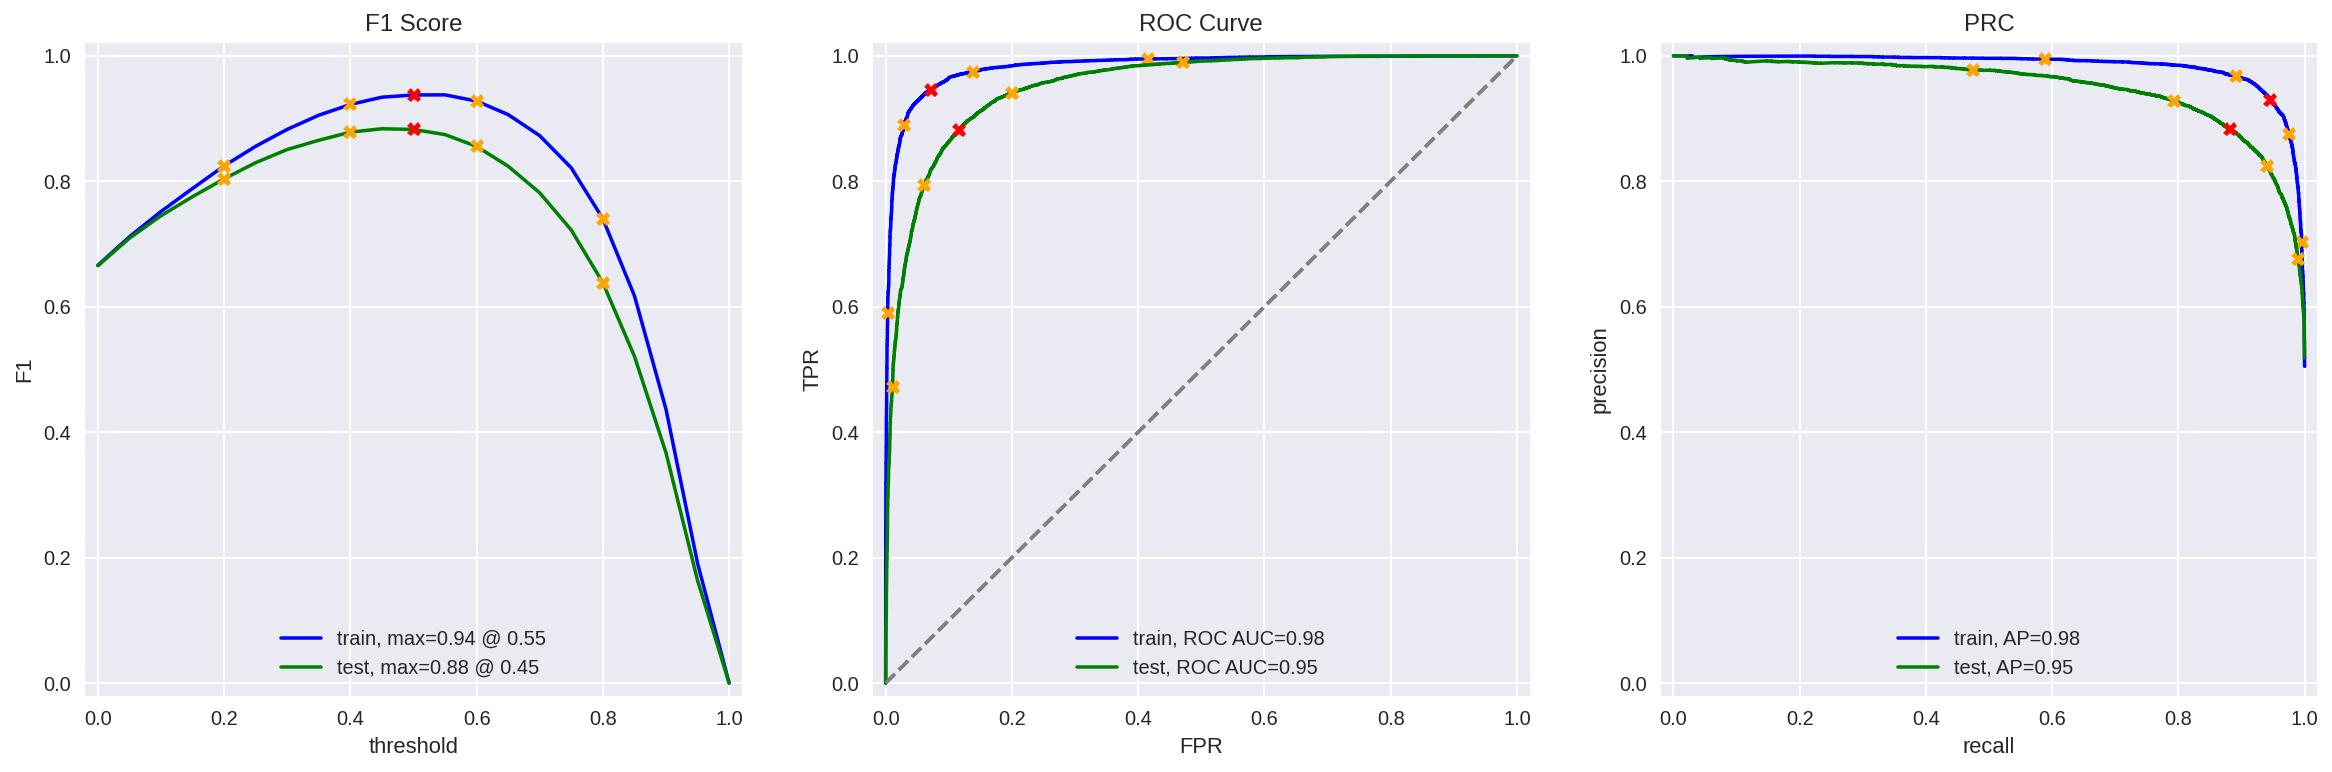

In [70]:
evaluate_model(model_2, train_bow_2, train_target, test_bow_2, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [71]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [72]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [73]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 1))
train_bow_3 = tfidf_vectorizer_3.fit_transform(train_features.apply(text_preprocessing_3))
test_bow_3 = tfidf_vectorizer_3.transform(test_features.apply(text_preprocessing_3))

In [74]:
print(train_bow_3.shape, test_bow_3.shape)
model_3 = LogisticRegression()
model_3.fit(train_bow_3, train_target)

(23796, 61213) (23535, 61213)


LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


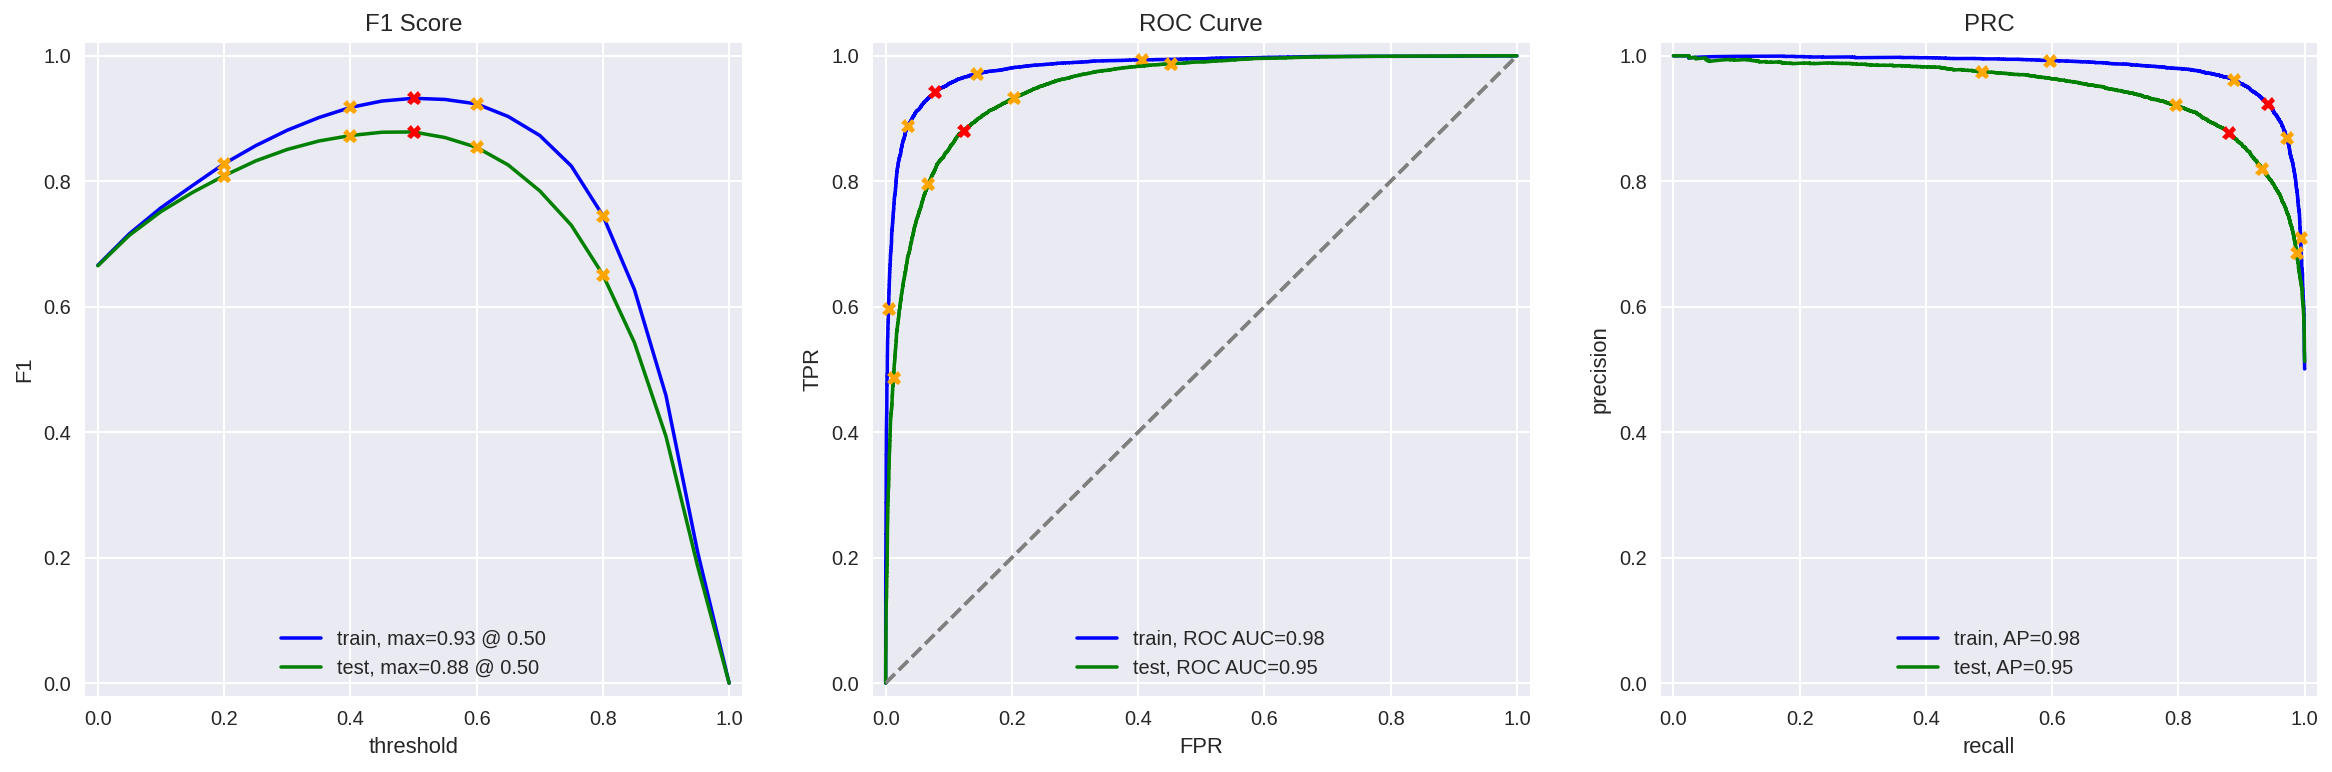

In [75]:
evaluate_model(model_3, train_bow_3, train_target, test_bow_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [76]:
from lightgbm import LGBMClassifier

In [77]:
tfidf_vectorizer_4 = TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 1))
train_bow_4 = tfidf_vectorizer_4.fit_transform(train_features.apply(text_preprocessing_3))
test_bow_4 = tfidf_vectorizer_4.transform(test_features.apply(text_preprocessing_3))

LGBMClassifier()

In [92]:
print(train_bow_4.shape, test_bow_4.shape)

(23796, 61213) (23535, 61213)


In [90]:
model_4 = LGBMClassifier(n_estimators=200)
model_4.fit(train_bow_4, train_target)

LGBMClassifier(n_estimators=200)

          train  test
Accuracy   0.96  0.87
F1         0.96  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


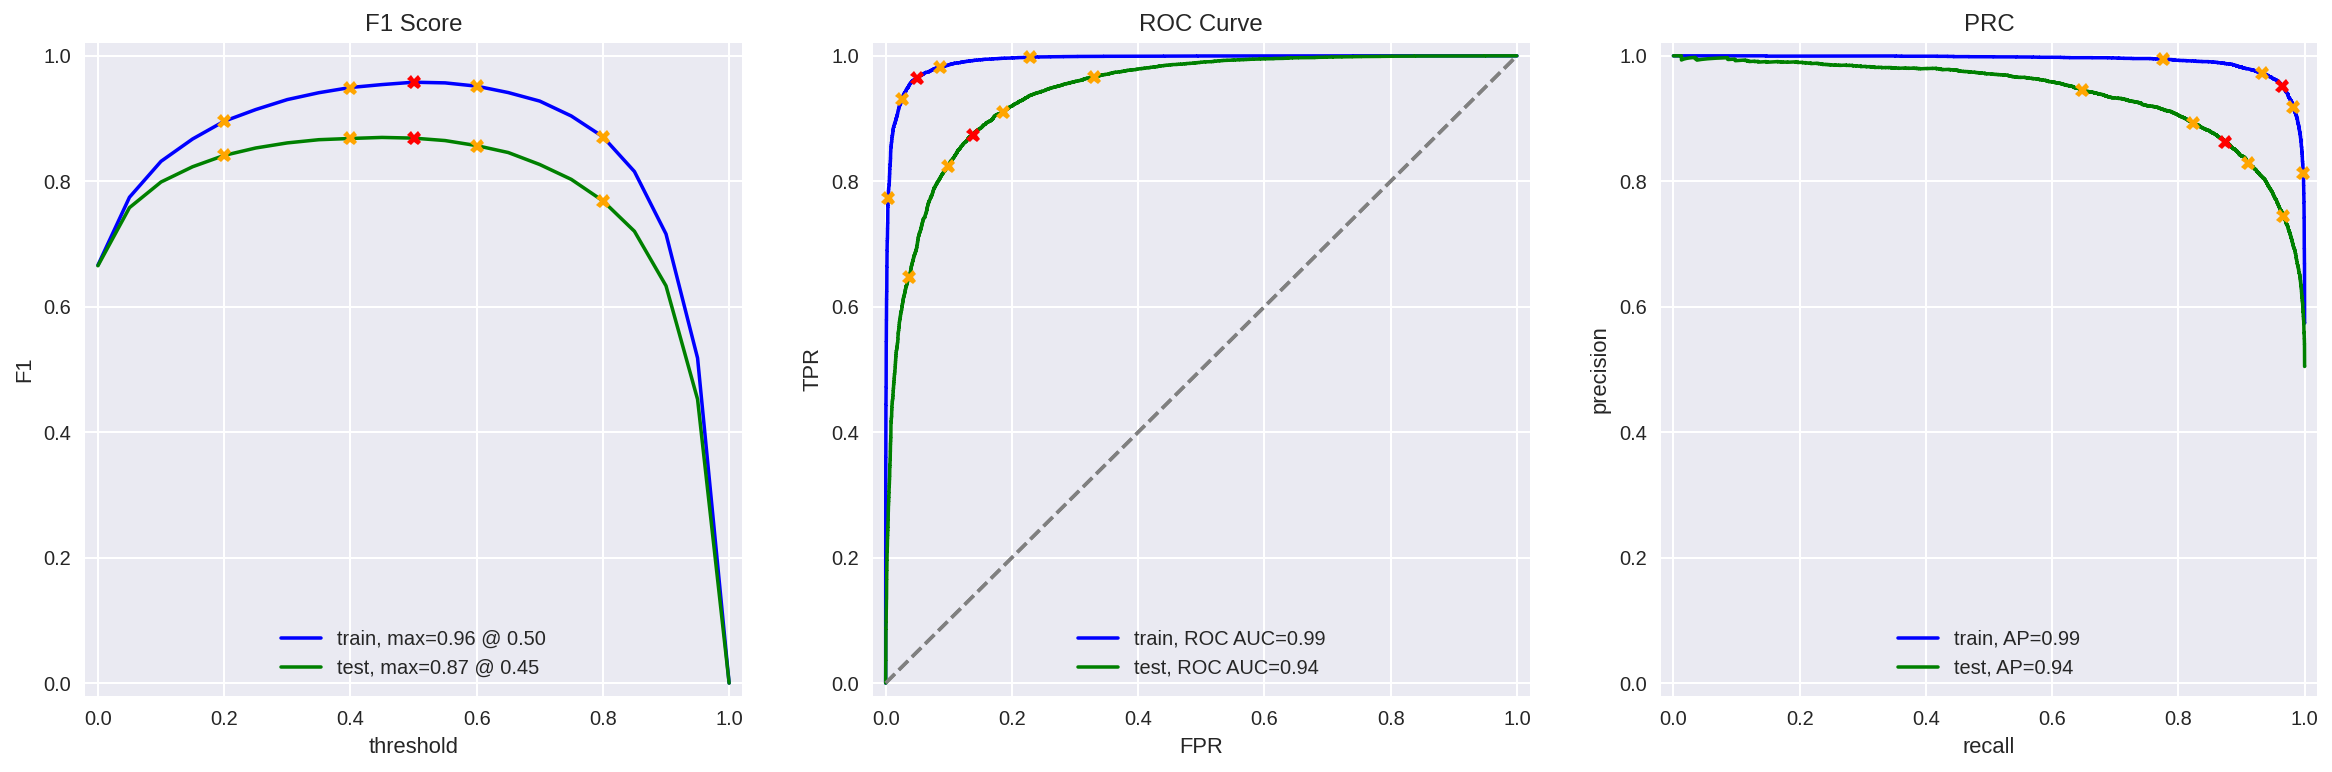

In [91]:
evaluate_model(model_4, train_bow_4, train_target, test_bow_4, test_target)

###  Model 9 - BERT

In [79]:
import torch
import transformers

In [80]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [81]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=33, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []
    
    # text to padded ids of tokens along with their attention masks
    for text in texts:
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids+[0]*(max_length-len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [82]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [83]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [84]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [85]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",I did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",Well I was bored and felt asleep in the middle...
2,I was really fascinated with the movie,I was really fascinated with the movie
3,Even the actors looked really old and disinter...,Even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,I didn't expect the reboot to be so good Write...
5,"The movie had its upsides and downsides, but I...",The movie had its upsides and downsides but I ...
6,What a rotten attempt at a comedy. Not a singl...,What a rotten attempt at a comedy Not a single...
7,Launching on Netflix was a brave move & I real...,Launching on Netflix was a brave move I really...


### Model 2

In [86]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  I did not simply like it not my kind of movie
0.16:  Well I was bored and felt asleep in the middle of the movie
0.54:  I was really fascinated with the movie
0.11:  Even the actors looked really old and disinterested and they got paid to be in the movie What a soul
0.31:  I didn't expect the reboot to be so good Writers really cared about the source material
0.47:  The movie had its upsides and downsides but I feel like overall it's a decent flick I could see myse
0.04:  What a rotten attempt at a comedy Not a single joke lands everyone acts annoying and loud even kids 
0.82:  Launching on Netflix was a brave move I really appreciate being able to binge on episode after episo


### Model 3

In [87]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  I did not simply like it not my kind of movie
0.12:  Well I was bored and felt asleep in the middle of the movie
0.50:  I was really fascinated with the movie
0.10:  Even the actors looked really old and disinterested and they got paid to be in the movie What a soul
0.27:  I didn't expect the reboot to be so good Writers really cared about the source material
0.50:  The movie had its upsides and downsides but I feel like overall it's a decent flick I could see myse
0.03:  What a rotten attempt at a comedy Not a single joke lands everyone acts annoying and loud even kids 
0.92:  Launching on Netflix was a brave move I really appreciate being able to binge on episode after episo


### Model 4

In [88]:
texts = my_reviews['review_norm']

#tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  I did not simply like it not my kind of movie
0.34:  Well I was bored and felt asleep in the middle of the movie
0.59:  I was really fascinated with the movie
0.37:  Even the actors looked really old and disinterested and they got paid to be in the movie What a soul
0.62:  I didn't expect the reboot to be so good Writers really cared about the source material
0.71:  The movie had its upsides and downsides but I feel like overall it's a decent flick I could see myse
0.22:  What a rotten attempt at a comedy Not a single joke lands everyone acts annoying and loud even kids 
0.80:  Launching on Netflix was a brave move I really appreciate being able to binge on episode after episo


### Model 9

In [89]:
# texts = my_reviews['review_norm']
# my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)
# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]
# for i, review in enumerate(texts.str.slice(0, 100)):
# print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

1.	All the models performed well above the dummy classifier and surpassed the F1 score threshold of 0.85.
2.	Of the 3 tested models, model_2(NLTK, TF-IDF & LR) performed the best, with F1 scores of 0.94(train) and 0.88(test).
3.	The BERT model was not used as kernel timed out several times. As suggested in the instructions, without powerful accelerators, it would be hard to utilize the BERT model.
4.	The tests on the my_reviews worked fairly well, even though some of the probabilities are not as satisfactory.

# Checklist

- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells executed without errors
- [x]  Conclusions are summarized